# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

2. I need to edit the levels of the training data so that anything where the signal is greater than 1 (due to high noise), should be normalised to 1

3. I may need to connect the features as images next to eachother, instead of channels in an input as the channels are cross effecting eachother in a negative way (where audio shoule be let through in one channel but bloced in one it is getting confused or assuming a relationship between channels when there is none)

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. maybe change how different samplerate images are concatenated
5. stop using cosine anealing as a straight learning rate is better

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout mel-warp")
    os.system("git pull origin mel-warp")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin main")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
from audioautoencoder.models.UNetRes12 import *
from audioautoencoder.models.UNetConv4 import *

## Test Model

In [5]:
BATCH_SIZE = 1
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 1, 1025 // 4, 175))
      #model = UNetRes12(in_channels=4, out_channels=4)
      model = UNetConv4(in_channels=1, out_channels=1)
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 1, 256, 175])


In [6]:
!pip install torchinfo

In [7]:
from torchinfo import summary

# For example, if the input size is (batch_size=2, channels=9, height=256, width=256):
summary(model, input_size=(2, 1, 1025 // 4, 175))


Layer (type:depth-idx)                   Output Shape              Param #
UNetConv4                                [2, 1, 256, 175]          --
├─Sequential: 1-1                        [2, 16, 122, 82]          --
│    └─Conv2d: 2-1                       [2, 16, 126, 86]          800
│    └─BatchNorm2d: 2-2                  [2, 16, 126, 86]          32
│    └─LeakyReLU: 2-3                    [2, 16, 126, 86]          --
│    └─Conv2d: 2-4                       [2, 16, 122, 82]          12,560
│    └─BatchNorm2d: 2-5                  [2, 16, 122, 82]          32
│    └─LeakyReLU: 2-6                    [2, 16, 122, 82]          --
├─Sequential: 1-2                        [2, 32, 58, 38]           --
│    └─Conv2d: 2-7                       [2, 32, 60, 40]           12,832
│    └─BatchNorm2d: 2-8                  [2, 32, 60, 40]           64
│    └─LeakyReLU: 2-9                    [2, 32, 60, 40]           --
│    └─Conv2d: 2-10                      [2, 32, 58, 38]           25,632
│ 

## Define Params

In [8]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.serialization.add_safe_globals([UNetConv4])
model = UNetConv4(in_channels=1, out_channels=1).to(device)


print(device)

cuda


In [9]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv4-mel-scale'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = 'remapped-signal-level' # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=learning_rates[i]*0.5
eta_min = base_lr
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 150
IMPORT_TRAIN_NOISY = train
batch_size = 128
num_workers = 12

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512*2)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [10]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [11]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [12]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [13]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb, timeout=40)
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_no_features(dataset_path, sample_size=8000)
        #scalers = train_scalers(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size,
          num_workers=num_workers
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Training set size: 80235
Validation set size: 20059
Training set size: 80235
Validation set size: 20059


## Inspect Data

In [14]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([1, 256, 175])


Found sample with SNR > 8:
SNR: 9.764022827148438
Index: 3
9.764022827148438
(1, 256, 175)
(256, 175)
Min, Max:  0.0 2.0867665
Min, Max:  0.0 2.0867367


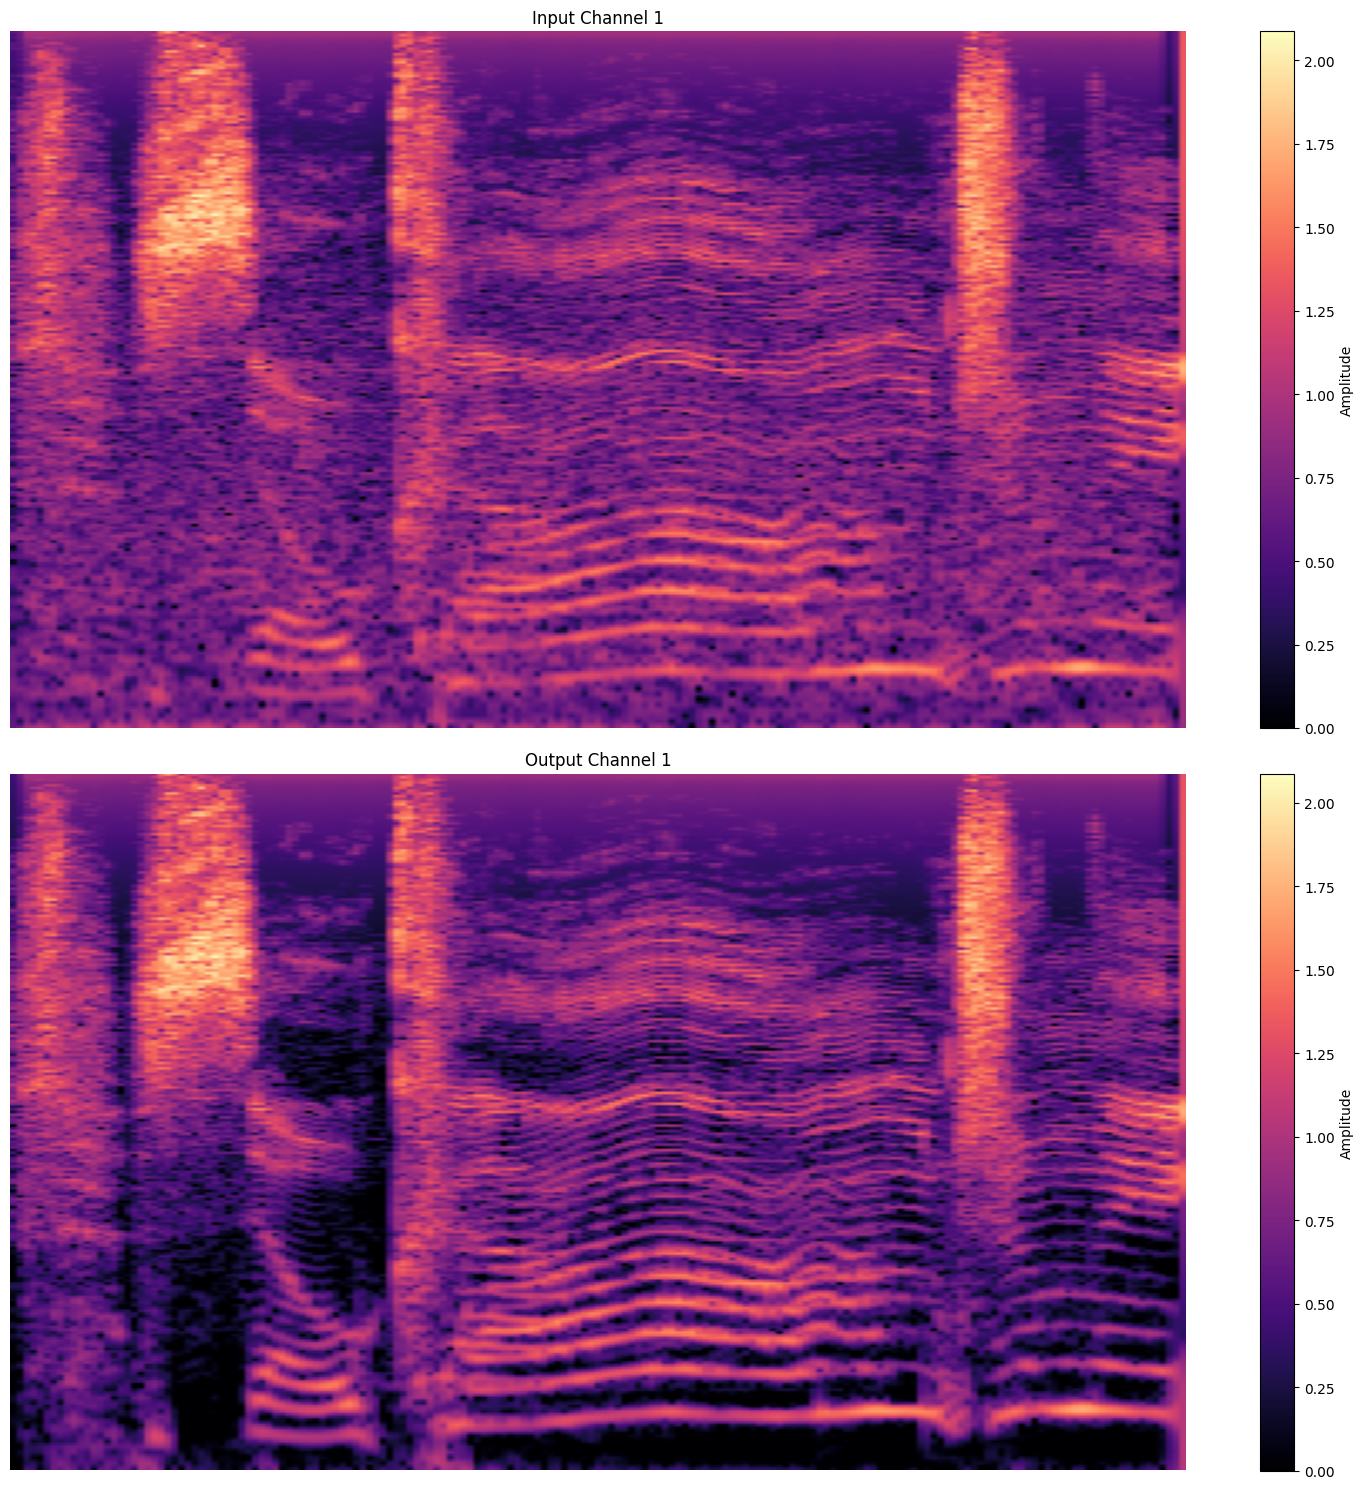

In [15]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample with SNR > 8
  for i in range(100):
      input_tensor, output_tensor, metadata = train_loader.train_dataset[i]
      if metadata['snr_db'] > 8:
          print("Found sample with SNR > 8:")
          print("SNR:", metadata['snr_db'])
          print("Index:", i)
          break  # exit loop after finding the first match



  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 15))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


Reverse the octave band encoding

## Train Model

In [16]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [17]:
import torch

torch.cuda.empty_cache()

In [18]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [19]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [20]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [21]:
from audioautoencoder.training import *

# plot example inputs



In [ ]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.1, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

Training on device: cuda
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/1254 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.1


Training:   5%|▌         | 63/1254 [00:54<09:12,  2.16batch/s, loss=loss: 0.2963, ref:0.3514]

___